# Getting Them Stonks: A (brief) Introduction to Portfolio Optimization
### Patricio Hernandez Senosiain 
---

## Contents:

>[1 - Introduction](#1---Introduction)
>
>[2 - Importing modules](#2---Importing-modules)
>
>[3 - Data retrieval](#3---Data-retrieval)
>
>[4 - Preprocessing](#4---Preprocessing)
>
>[5 - Modelling](#5---Modelling)
>


## 1 - Introduction

### **Scenario:** You won the lottery, recieved the paycheck for your summer internship, or that distant uncle you didn't even know passed and left you some money... what do you do?
### **A:** Invest... but how?

(Simple) recipe for investment:

1. Define a goal/strategy
2. Pick suitable assets
3. **Construct a suitable portfolio**
4. Check and repeat

### **Q:** Given $n$ assets, what is the optimal allocation of these within a portfolio?
### **A:** There are many...

### The Mean-Variance framework:
- Developed by Harry Markowitz in 1952 (earned him Nobel Price in Economics)
- Aims to solve the above problem using two ingredients:
    1. The volatility of asset returns (risk) - for stocks, this is the average log first difference in stock prices
    2. The expected asset returns (reward) - for stocks, this is the sample covariance of periodic returns
- Shortcomings:
    - Stock returns can be non-stationary $\implies$ we can't use average returns as a reasonable forecast
    - Stock returns are notoriously hard to forecast (Efficient Market Hypothesis)
    
### Goal: Using the M-V framework, find the optimal fraction (weight) for each asset in our portfolio

## 2 - Importing modules

In [1]:
from random import random
from random import seed
import numpy as np
from numpy.random import default_rng
import pandas as pd
import cvxpy as cp
from scipy.spatial import ConvexHull
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))


np.random.seed(1)
seed(1)
%matplotlib inline

## 3 - Data retrieval

First, we need to gather data on stock prices for a selection of assets. We focus our attention on [Russell 1000 Index](https://en.wikipedia.org/wiki/Russell_1000_Index) during the period Feb 2019 - Feb 2021.

In [2]:
# Specify asset symbols
stocks = ['GOOG', 'AAPL', 'FB', 'BABA', 'AMZN', 'GE', 'AMD', 'NFLX', 'BAC', 'GM',
          'T', 'UAA', 'XOM', 'RRC', 'BBY', 'MA', 'PFE', 'JPM']
data = web.DataReader(stocks, 'yahoo', start='2018/02/10', end='2021/02/10')
data.head()

Attributes    Adj Close                                                  \
Symbols            GOOG       AAPL          FB        BABA         AMZN   
Date                                                                      
2018-02-12  1051.939941  39.245506  176.410004  177.440002  1386.229980   
2018-02-13  1052.099976  39.638657  173.149994  179.250000  1414.510010   
2018-02-14  1069.699951  40.369492  179.520004  186.759995  1451.050049   
2018-02-15  1089.520020  41.725037  179.960007  187.449997  1461.760010   
2018-02-16  1094.800049  41.589962  177.360001  183.679993  1448.689941   

Attributes                                                      ...  \
Symbols            GE    AMD        NFLX        BAC         GM  ...   
Date                                                            ...   
2018-02-12  13.722147  11.68  257.950012  28.954248  38.254375  ...   
2018-02-13  13.583260  11.78  258.269989  29.010075  37.707878  ...   
2018-02-14  13.796224  12.20  266.000000  29.773008  38.081322  ...   
2018-02-15  13.749924  12.19  280.269989  29.968393  38.117744  ...   
2018-02-16  13.935109  11.82  278.519989  29.745096  37.425522  ...   

Attributes      Volume                                                  \
Symbols            BAC          GM           T         UAA         XOM   
Date                                                                     
2018-02-12  95055100.0  19392000.0  27750700.0  12275300.0  19340400.0   
2018-02-13  76727300.0   8937200.0  22877200.0  34064200.0  11926600.0   
2018-02-14  97251500.0  10271600.0  24834200.0  19153300.0  17188400.0   
2018-02-15  68117400.0   9715800.0  27507200.0  13702600.0  14432400.0   
2018-02-16  62137800.0  14871800.0  19901600.0  13755300.0  13722400.0   

Attributes                                                            
Symbols            RRC        BBY         MA         PFE         JPM  
Date                                                                  
2018-02-12   8504700.0  3257700.0  5227400.0  38743670.0  18043300.0  
2018-02-13   5099600.0  2881600.0  3471000.0  21559570.0  16358200.0  
2018-02-14   9274100.0  3602700.0  4203700.0  24494749.0  15186900.0  
2018-02-15  11773300.0  2283900.0  3915000.0  22588379.0  12130200.0  
2018-02-16   7499300.0  2165700.0  4213100.0  27659595.0  13214300.0  

[5 rows x 108 columns]

## 4 - Preprocessing

In [3]:
data = data['Adj Close']
data.head()

Symbols,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,NFLX,BAC,GM,T,UAA,XOM,RRC,BBY,MA,PFE,JPM
Date,,,,,,,,,,,,,,,,,,
2018-02-12,1051.939941,39.245506,176.410004,177.440002,1386.229980,13.722147,11.68,257.950012,28.954248,38.254375,30.105310,14.230000,64.415543,12.799002,64.917915,165.515198,29.364902,102.015762
2018-02-13,1052.099976,39.638657,173.149994,179.250000,1414.510010,13.583260,11.78,258.269989,29.010075,37.707878,30.295685,16.700001,64.314377,12.485156,64.687233,167.414520,29.602127,102.645706
2018-02-14,1069.699951,40.369492,179.520004,186.759995,1451.050049,13.796224,12.20,266.000000,29.773008,38.081322,30.138416,17.760000,64.449257,12.887270,66.920364,169.776367,29.813931,105.019440
2018-02-15,1089.520020,41.725037,179.960007,187.449997,1461.760010,13.749924,12.19,280.269989,29.968393,38.117744,30.626795,18.410000,64.238518,13.367846,67.658592,171.911850,30.254484,105.457664
2018-02-16,1094.800049,41.589962,177.360001,183.679993,1448.689941,13.935109,11.82,278.519989,29.745096,37.425522,30.742676,17.360001,64.516693,13.024577,67.529411,172.856552,30.720463,104.699898


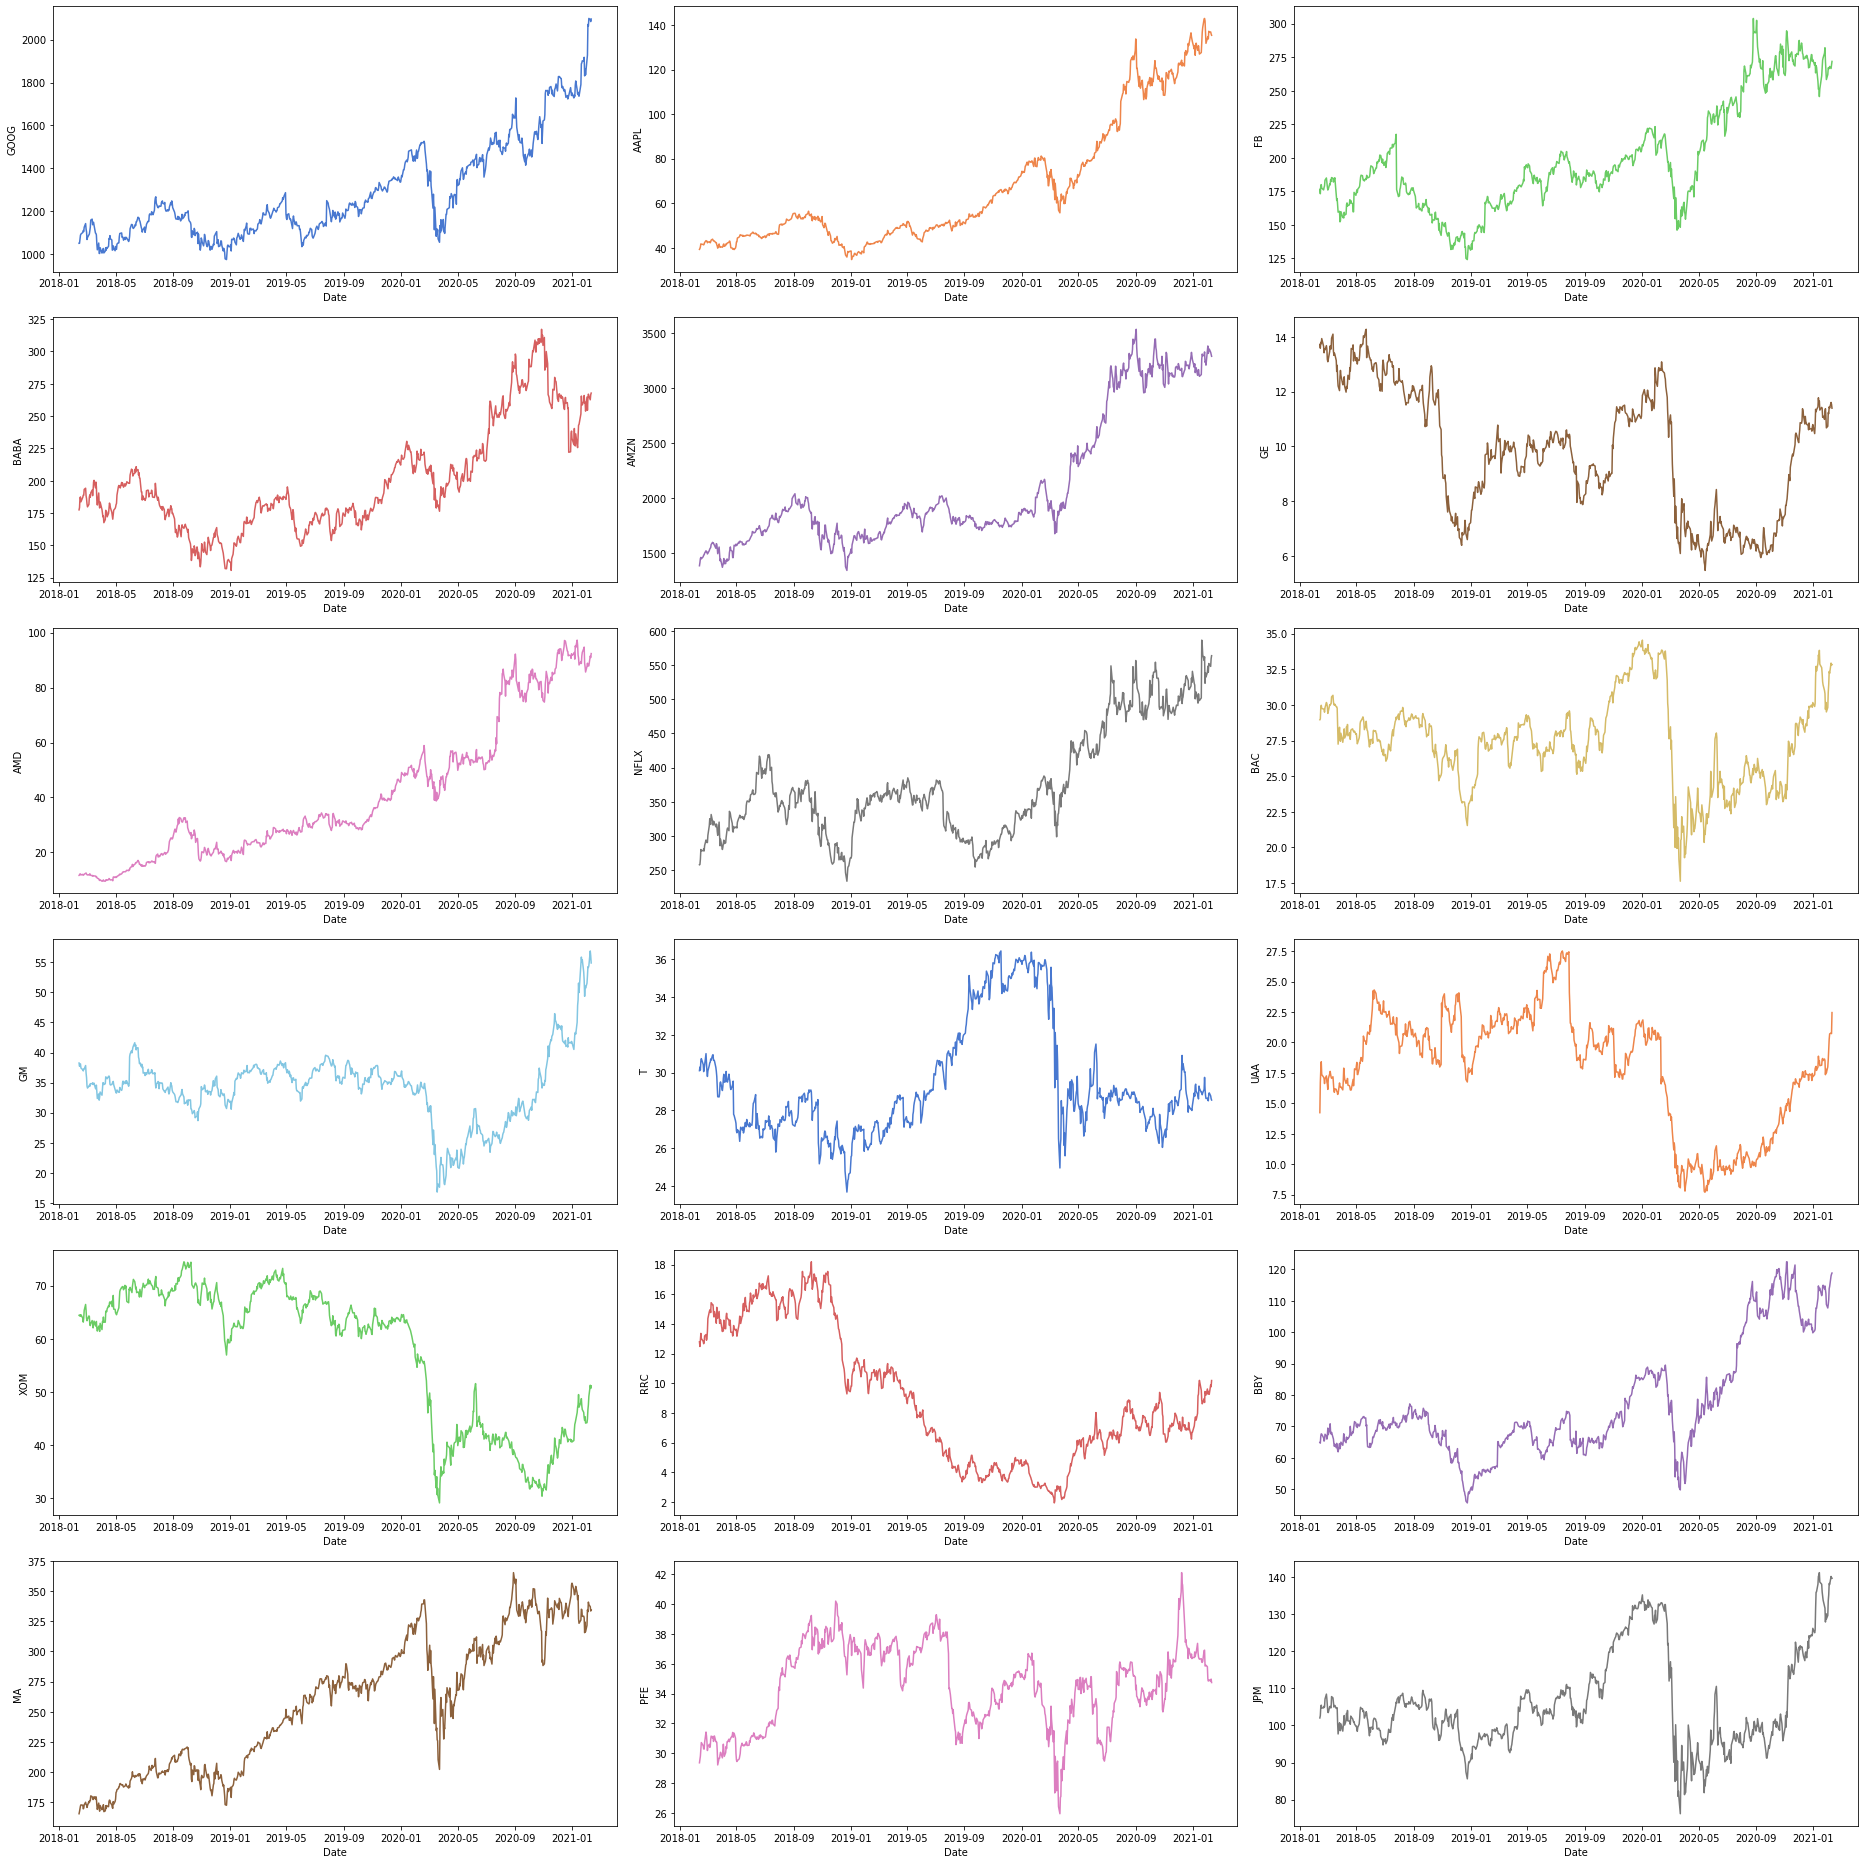

In [4]:
fig, axs = plt.subplots(6, 3)
fig.set_size_inches(26, 26)
for i in range(len(stocks)):
    sns.lineplot(data=data.iloc[:, i].dropna(),
                 ax=axs[i//3, i % 3],
                 color=standard_palette[i])

plt.tight_layout()
plt.savefig('fig_1.png')

In [5]:
returns = (np.log(data)).diff(30)

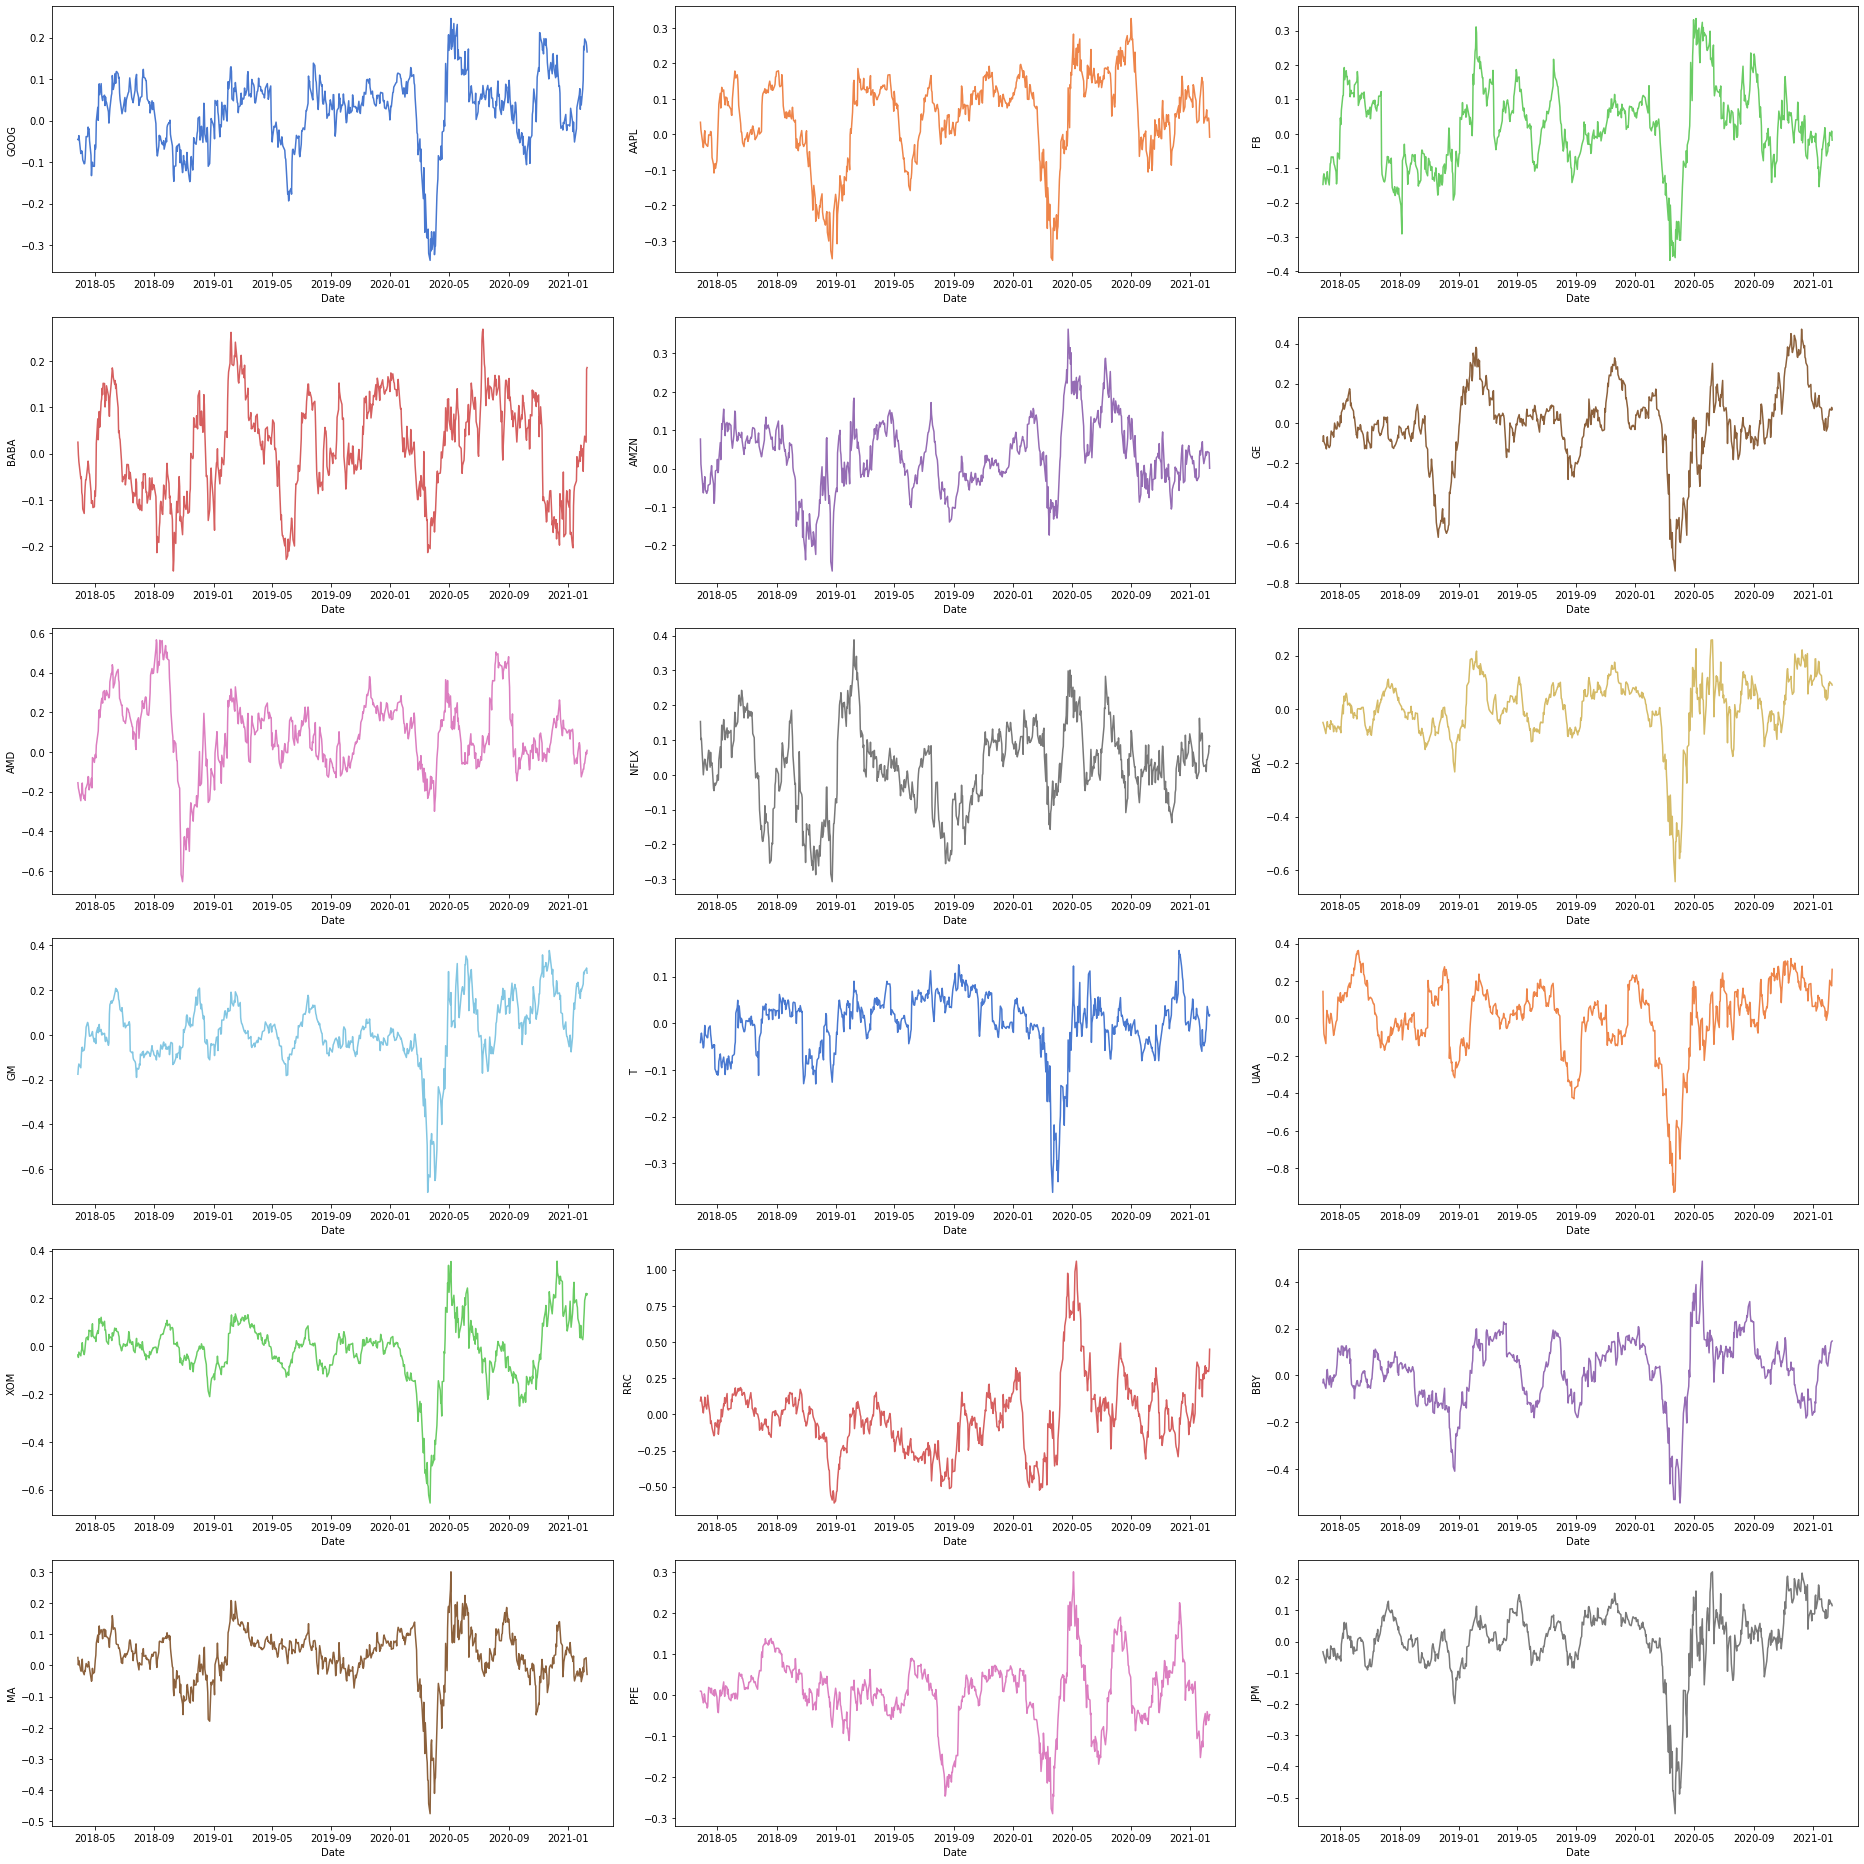

In [6]:
fig, axs = plt.subplots(6, 3)
fig.set_size_inches(26, 26)
for i in range(len(stocks)):
    sns.lineplot(data=returns.iloc[:, i].dropna(),
                 ax=axs[i//3, i % 3],
                 color=standard_palette[i])

plt.tight_layout()
plt.savefig('fig_2.png')

In [7]:
ex_returns = returns.mean()
cov_returns = returns.cov()

## 5 - Modelling

#### Goal:

#### $\mathbf{w}=\begin{bmatrix}
w_1\\
\vdots \\
w_n
\end{bmatrix}$

#### Ingredients:

#### $\boldsymbol{\mu}=\begin{bmatrix}
\mu_1\\
\vdots \\
\mu_1
\end{bmatrix} \quad,\quad \boldsymbol{\Sigma} = \begin{bmatrix}
\sigma_{11} & \dots & \sigma_{n1}\\
\vdots & \ddots & \vdots\\
\sigma_{1n} & \dots & \sigma_{nn}
\end{bmatrix}$

#### Plan of Attack:
1. Define our objective function
2. OPTIMIZE!
3. Analyze solutions

In [8]:
# Defining weights vector
n = len(stocks)
w = cp.Variable(n)

### Feasible set of portfolios... convex hull?

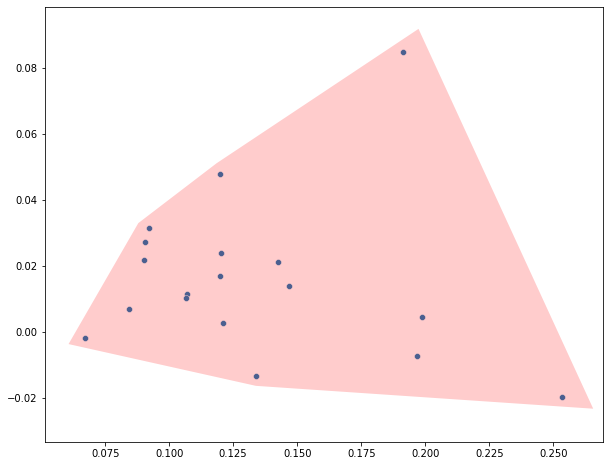

In [9]:
stock_return_vol = returns.std()
singleton_portfolios = {'Volatility': stock_return_vol, 'Returns': ex_returns}

points = (pd.DataFrame(data=singleton_portfolios)).to_numpy()


hull = ConvexHull(points)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(x=points[:, 0],
                y=points[:, 1], ax=axs)

cent = np.mean(points, 0)
pts = []
for pt in points[hull.simplices]:
    pts.append(pt[0].tolist())
    pts.append(pt[1].tolist())

pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                  p[0] - cent[0]))
pts = pts[0::2]  # Deleting duplicates
pts.insert(len(pts), pts[0])
k = 1.1
color = 'red'
poly = Polygon(k*(np.array(pts) - cent) + cent,
               facecolor=color, alpha=0.2)

poly.set_capstyle('round')
plt.gca().add_patch(poly)
plt.savefig('fig_3.png')
plt.show()

### Brute force approach: Monte Carlo simulation (100 samples)

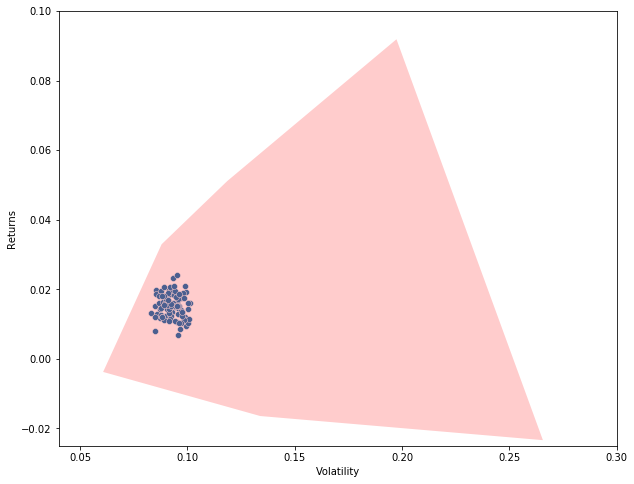

In [10]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 100

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

simulations = {'Returns': p_ret, 'Volatility': p_vol,
               'Type': np.ones(num_portfolios)}
long_simulated_portfolios = pd.DataFrame(simulations)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=long_simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs)

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.04, 0.3))
axs.set(ylim=(-0.025, 0.1))
plt.savefig('fig_4.png')
plt.show()

### Monte Carlo simulation (1,000 samples)

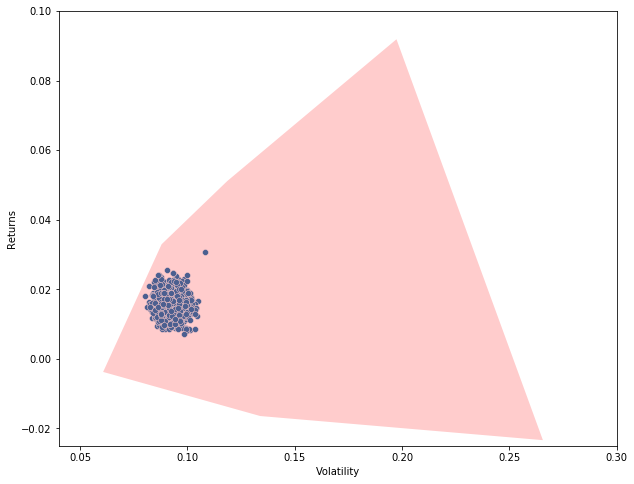

In [11]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 1000

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)

    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

simulations = {'Returns': p_ret, 'Volatility': p_vol,
               'Type': np.ones(num_portfolios)}
long_simulated_portfolios = pd.DataFrame(simulations)


f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=long_simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs)

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.04, 0.3))
axs.set(ylim=(-0.025, 0.1))
plt.savefig('fig_5.png')
plt.show()

### Monte Carlo simulation (500,000 samples)

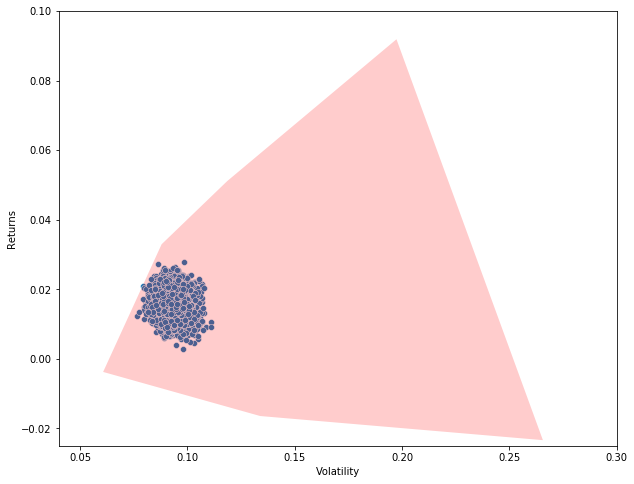

In [12]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 500000

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

simulations = {'Returns': p_ret, 'Volatility': p_vol,
               'Type': np.ones(num_portfolios)}
long_simulated_portfolios = pd.DataFrame(simulations)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=long_simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs)

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.04, 0.3))
axs.set(ylim=(-0.025, 0.1))
plt.savefig('fig_6.png')
plt.show()

### Monte Carlo simulation (10,000 samples - NOW WITH SHORTING!)

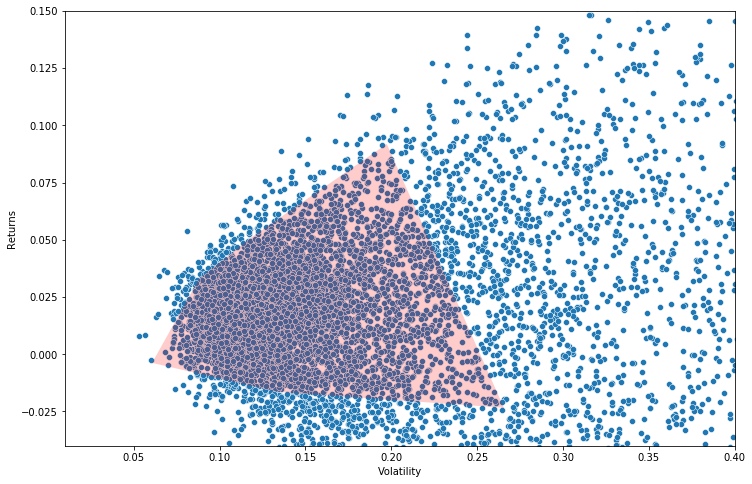

In [13]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weights = 2*np.random.rand(n) - 1
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)
simulations = {'Returns': p_ret, 'Volatility': p_vol,
               'Type': np.ones(num_portfolios)}

simulated_portfolios = pd.DataFrame(simulations)


f, axs = plt.subplots(figsize=(12, 8))


sns.scatterplot(data=simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs)

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_7.png')
plt.show()

### Model 1: Minimum volatility (long-only)

#### $ \underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma}\: \mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T \mathbf{1}=1 \quad , \quad w_i\geq 0$


In [14]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [w >= 0,
               (np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 0.0027965843236642802
Solution weight is
[-4.41453245e-22  2.90467764e-23 -1.17825238e-23  1.41650639e-01
  7.97610644e-02 -3.85721014e-21  1.41813598e-21  4.86773034e-02
 -1.47559855e-21 -1.88894985e-21  4.90739658e-01 -3.75820485e-22
 -1.19789722e-21  4.44264790e-21  8.02400069e-22 -8.52246801e-22
  2.39171335e-01 -1.45240934e-21]


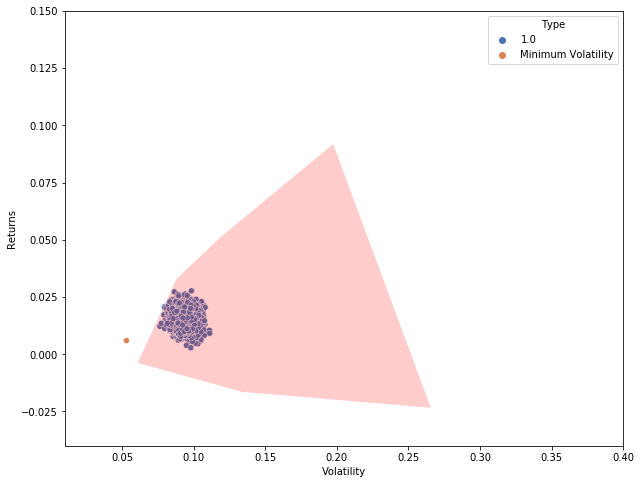

In [15]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5

simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Minimum Volatility'}, ignore_index=True)

long_simulated_portfolios = long_simulated_portfolios.append({'Returns': ret,
                                                              'Volatility': vol,
                                                              'Type': 'Minimum Volatility'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=long_simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_8.png')
plt.show()

### Model 2: Minimum volatility

#### $ \underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma}\: \mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T \mathbf{1}=1 \quad$


In [16]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 0.0012304523905180167
Solution weight is
[-0.06136286 -0.0030179  -0.07141762  0.22144716  0.14710399 -0.02910159
 -0.11725762  0.15064979 -0.45359485  0.07729424  0.43004778 -0.10065659
 -0.06194051  0.00517446 -0.14114823  0.11639217  0.3608415   0.53054668]


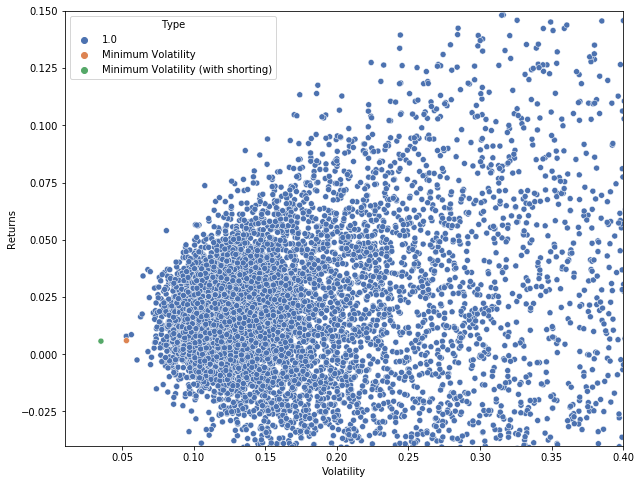

In [17]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Minimum Volatility (with shorting)'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_9.png')
plt.show()

### Model 3: Risk-efficient

#### $ \underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w}$
#### $\textrm{s.t}\quad \boldsymbol{\mu}^T\!\mathbf{w} \geq \mu^* \quad , \quad \mathbf{w}^T \mathbf{1}=1 $

In [18]:
# Defining target return rate in (0,0.25]
mu = (random())/4

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w >= mu,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('Target return rate: ', mu)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

Target return rate:  0.033591061028100305

The optimal value is 0.0020140866494029385
Solution weight is
[ 0.05057208  0.21870641 -0.1345835   0.10235907  0.05349013 -0.1179872
 -0.05823575  0.27953896 -0.73449273  0.19394288  0.11452732 -0.1135656
 -0.1892412  -0.0429969  -0.19401742  0.27697738  0.371446    0.92356005]


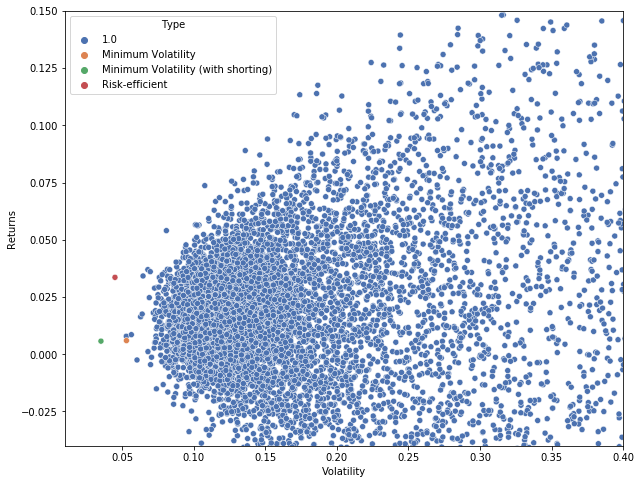

In [19]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Risk-efficient'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_10.png')
plt.show()

### Model 4: Return-efficient

#### $ \underset{\mathbf{w}}{\text{max}} \quad \boldsymbol{\mu}^T\!\mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w} \leq \sigma^{2*} \quad , \quad \mathbf{w}^T \mathbf{1}=1$

In [20]:
# Defining target volatility in [0,0.1)
sigma = (random())/10

# Creating objective function and constraints
objective = (ex_returns.to_numpy())@w
constraints = [cp.quad_form(w, cov_returns) <= sigma**2,
               (np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()

# Print result
print('target volatility: ', sigma)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

target volatility:  0.08474337369372327

The optimal value is 0.08250487847293148
Solution weight is
[ 0.24710207  0.60799658 -0.24548691 -0.10672861 -0.11087128 -0.27404709
  0.04539076  0.50583455 -1.22767144  0.39874707 -0.43944445 -0.13623004
 -0.41274808 -0.12757326 -0.28684211  0.55892344  0.39006502  1.61358381]


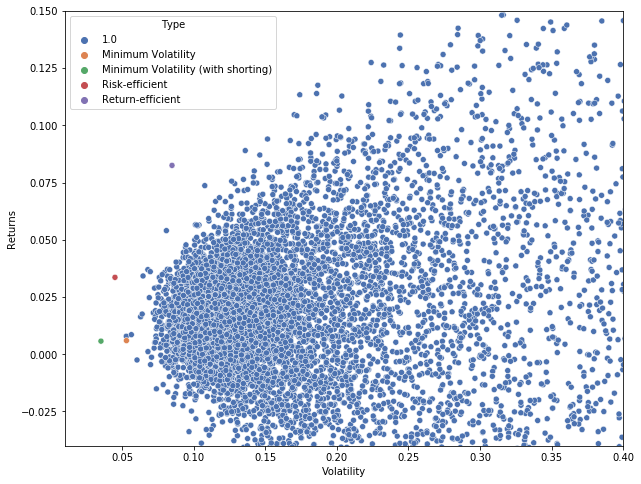

In [21]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Return-efficient'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_11.png')
plt.show()

### Putting it all together - duality, quadratic risk utility,and the efficient frontier

#### $ \underset{\mathbf{w}}{\text{min}} \quad \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w} \; - \; \lambda \boldsymbol{\mu}^T\!\mathbf{w}$
#### $\textrm{s.t} \quad \mathbf{w}^T \mathbf{1}=1 $


#### Here, $\lambda$ is the risk aversion parameter


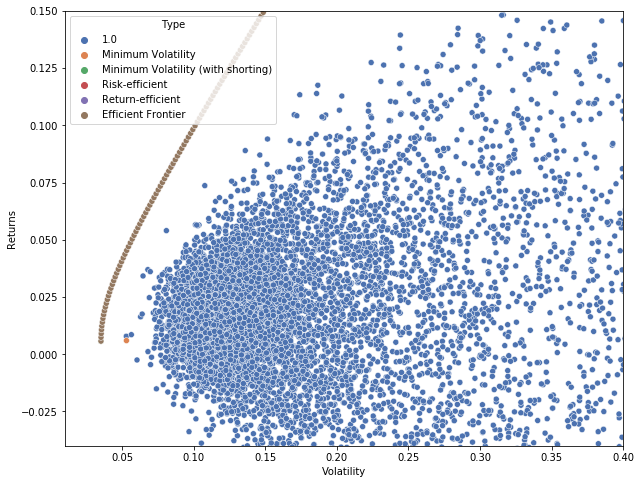

In [22]:
# Creating lambda sample
lmbda = cp.Parameter(nonneg=True)
LMBDA_SPACE = np.linspace(0, 20, num=6000)

# Declaring problem
objective = cp.quad_form(w, cov_returns)-lmbda*((ex_returns.to_numpy())@w)
constraints = [(np.ones(n))@w == 1]

problem = cp.Problem(cp.Minimize(objective), constraints)

efficient_frontier = simulated_portfolios

# Solving problem for different lambda parameters
for l in LMBDA_SPACE:
    lmbda.value = l
    problem.solve()
    weights = w.value
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    efficient_frontier = efficient_frontier.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Efficient Frontier'}, ignore_index=True)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=efficient_frontier,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_12.png')
plt.show()

### But wait... what if we can't short?

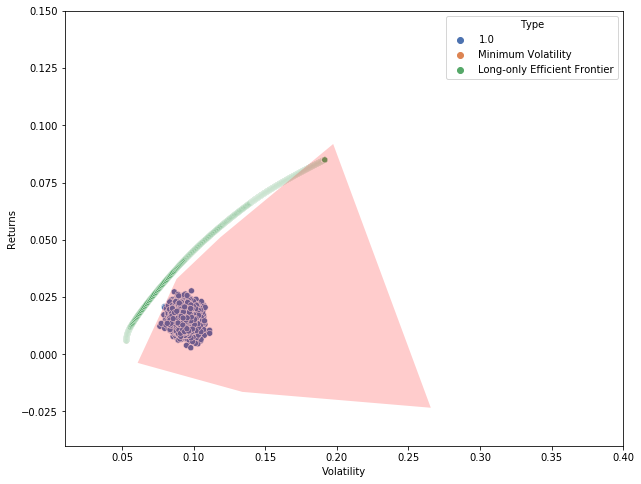

In [23]:
# Declaring problem
objective = cp.quad_form(w, cov_returns)-lmbda*((ex_returns.to_numpy())@w)
constraints = [(np.ones(n))@w == 1,
               w >= 0]

problem = cp.Problem(cp.Minimize(objective), constraints)

# Solving problem for different lambda parameters
for l in LMBDA_SPACE:
    lmbda.value = l
    problem.solve()
    weights = w.value
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    long_simulated_portfolios = long_simulated_portfolios.append({'Returns': ret,
                                                                  'Volatility': vol,
                                                                  'Type': 'Long-only Efficient Frontier'},
                                                                 ignore_index=True)

f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=long_simulated_portfolios,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.15))
plt.savefig('fig_13.png')
plt.show()

### Model 5: Maximum Sharpe Ratio
#### $ \underset{W}{\text{max}} \frac{R^T\!W - r_f}{\sqrt{\mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w}}}$
#### $\textrm{s.t}\quad \sum_{i=1}^{n}{w_i}=1$

### ...
### STOP!!! THIS IS NOT A CONVEX PROBLEM

#### Assume there exsists $ W$ such that $\; R^TW \; -  \; r_f \geq 0 $ 
#### (this is not unreasonable)


#### $\implies \underset{y,\kappa}{\text{min}} \quad  y^T\:\Sigma \: y $
#### $\quad \textrm{s.t}\quad \sum_{i=1}^{n}{(r_i-r_f)y_i}=1 \quad , \quad \sum_{i=1}^{n}{y_i}=\kappa \quad \implies w^*=\frac{y^*}{\kappa^*}$

In [24]:
# Set risk-free rate (monthly)
r = 0.002083

# Creating objective function and constraints
k = cp.Variable()
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy() - r)@w == 1,
               (np.ones(n))@w == k,
               k >= 0]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

max_sharpe = ((ex_returns.to_numpy())@w.value - r) / \
    ((w.value@cov_returns@w.value)**0.5)
# Print result
print('Optimal kappa: ', k.value)
print('Optimal Sharpe: ', max_sharpe)
print("Solution weight is")
print((w.value / k.value))

Optimal kappa:  2.9615385346564382
Optimal Sharpe:  1.00472078099366
Solution weight is
[ 1.28065372  2.65529149 -0.82872942 -1.20633029 -0.97525649 -1.09477382
  0.59037063  1.69593498 -3.82135123  1.47582455 -3.35280762 -0.25542602
 -1.58818099 -0.57236428 -0.77501044  2.04168928  0.4879816   5.24248436]


Return, 0.3397453293257292
Vol, 0.33744895607557157


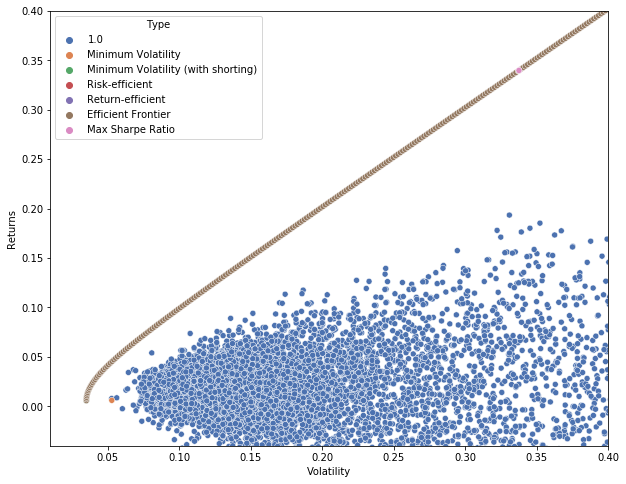

In [26]:
weights = (w.value / k.value).round(16) + 0.0
ret = (ex_returns.to_numpy())@weights
print('Return,', ret)
vol = (weights@cov_returns@weights)**0.5
print('Vol,', vol)
efficient_frontier = efficient_frontier.append({'Returns': ret,
                                                'Volatility': vol,
                                                'Type': 'Max Sharpe Ratio'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
sns.scatterplot(data=efficient_frontier,
                x='Volatility',
                y='Returns',
                ax=axs, hue='Type',
                palette="deep")

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.4))
plt.savefig('fig_14.png')
plt.show()

## Lessons to be learned:
### 1. Correlation matters
### 2. Pick in the frontier
### 3. Know your limits

## 7 - References
